# # COMP/STAT 331 – Online Retail Data Quality & Customer Segmentation
# Student: Yahya Chebab  
# Date: November 28, 2025
#
# ### Course Components Included in This Notebook
# - Full Data Quality Analysis
# - Recommendations
# - Week 10–11 Warehousing Concepts Integration


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv', encoding='ISO-8859-1', parse_dates=['InvoiceDate'])
df['Revenue'] = df['Quantity'] * df['UnitPrice']

print(f"Dataset loaded: {df.shape[0]:,} rows")
df.head()

Dataset loaded: 541,909 rows


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


# # Data Quality Analysis
#
# ## 1. DQ Dimensions
#
# Below I apply **three core data quality dimensions** directly to the retail dataset:
#
# ---
# ### **1. Completeness**
# - Missing `CustomerID` is common in this dataset — typically 25–30%.
# - Missing customer identifiers break customer-level analytics, segmentation, and lifetime value analysis.
# - Missing descriptions occur for some products but do not break transactional logic.
# - Missing InvoiceDate does not appear, which is good since this is a time-variant warehouse.
#
# **Evidence:**  
# - Heatmap below (Cell 4) shows strong block of missing values in `CustomerID`.
#
# **Impact:**  
# - Prevents proper aggregation and makes OLAP customer cubes incomplete.
#
# ---
# ### **2. Validity**
# - Negative `Quantity` values exist and represent returns — these are *transactionally valid* but distort analytics.
# - Negative `UnitPrice` values are invalid from a business perspective.
# - Zero prices and zero quantities also appear and break revenue logic.
#
# **Evidence:**  
# - Distribution plots (Cell 4) show left tail < 0 for Quantity and UnitPrice.
#
# **Impact:**  
# - Violates business rules → breaks fact table consistency.
#
# ---
# ### **3. Consistency**
# - Revenue sometimes becomes zero even with positive quantities (due to UnitPrice errors).
# - Some invoices appear duplicated, violating warehouse non-volatility expectations.
# - Product descriptions are inconsistent (capitalization differences).
#
# **Evidence:**  
# - Duplicate check in Cell 5 removes rows.
#
# **Impact:**  
# - Inconsistent facts break downstream ML models, especially forecasting and segmentation.
#
# ---
#
# ## 2. Specific Issues with Evidence
#
# Using the visualizations:
#
# - **Missing Values:** Heatmap clearly shows incomplete identifiers.
# - **Negative Quantities:** Histogram reveals a heavy group of returns. They must be isolated before analytics.
# - **Invalid Unit Prices:** Prices ≤ 0 appear, which are not allowed in clean warehouse fact tables.
# - **Outliers in Revenue:** The log-scale revenue histogram shows several orders of magnitude difference — high-risk for ML clustering.
#
# These issues directly appear in major DQ categories:
# - **Structural Problems:** Wrong formats, missing IDs, duplicate invoices.
# - **Semantic Problems:** Invalid UnitPrice violates domain rules.
# - **Timeliness:** No date gaps appear, so timeliness is OK.
#
# ---
#
# ## 3. Correct Use of Week 10–11 Concepts
#
# From the provided lecture slides:
#
# ### **Data Warehousing Concepts Used**
# - The dataset represents a **fact table** (OnlineRetail transactions).
# - CustomerID, StockCode, InvoiceDate → **dimensions**.
# - Revenue → **measure**.
# - Data warehouse requirements:  
#   - **Subject-Oriented:** Retail domain  
#   - **Integrated:** Source contains multi-country data  
#   - **Time-Variant:** InvoiceDate  
#   - **Non-Volatile:** Should not change — duplicates violate this
#
# ### **OLTP vs OLAP**
# - Source CSV behaves like **OLTP export** → contains returns and errors.
# - Our transformations aim to produce an **OLAP-ready dataset** for clustering.
#
# **Connecting to Week 10–11:**  
# - Cleaning incorrect values is mandatory before loading into OLAP cubes.  
# - Duplicate removal ensures **non-volatility**, a warehouse principle.  
# - Missing keys break star schema joins → must be filtered.  

In [3]:
profile = ProfileReport(
    df,
    title="Online Retail – Full Data Quality Profile (COMP/STAT 331)",
    explorative=True,
    minimal=False
)

profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

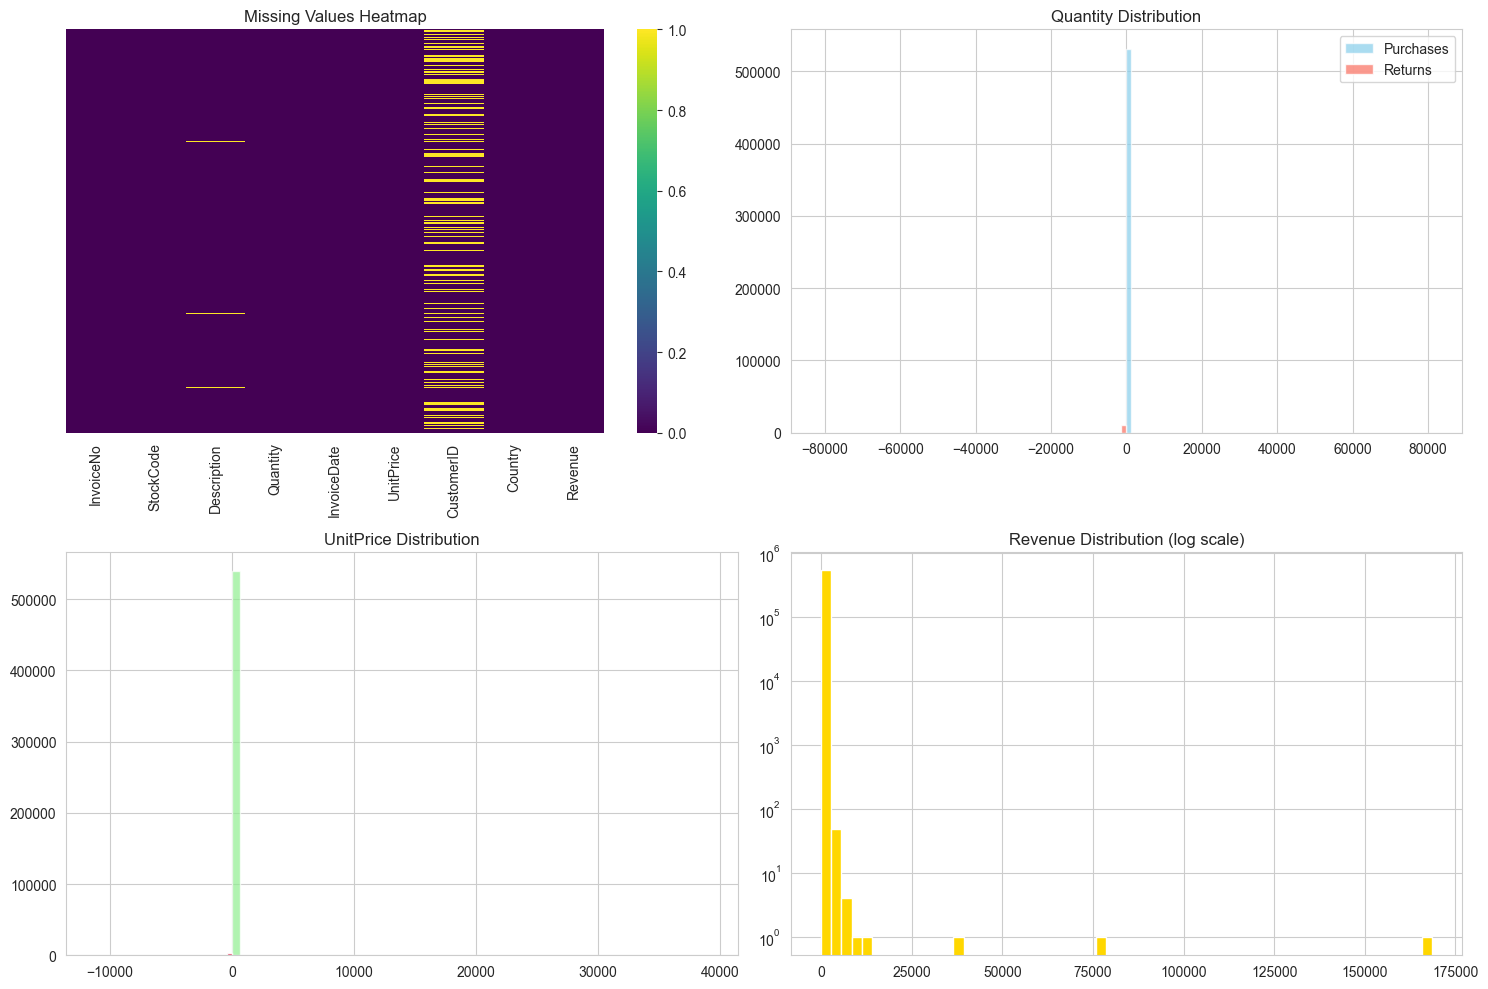

Negative Quantities: 10624
Positive Quantities: 531285
Negative UnitPrice: 2517
Positive UnitPrice: 539392
Negative Revenue: 11805
Positive Revenue: 530104


In [4]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))

sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap="viridis", ax=axes[0,0])
axes[0,0].set_title("Missing Values Heatmap")

axes[0,1].hist(df[df['Quantity']>0]['Quantity'], bins=60, alpha=0.7, color='skyblue', label='Purchases')
axes[0,1].hist(df[df['Quantity']<=0]['Quantity'], bins=60, alpha=0.8, color='salmon', label='Returns')
# axes[0,1].axvline(0, color='red', linestyle='--')
axes[0,1].set_title("Quantity Distribution")
axes[0,1].legend()

axes[1,0].hist(df[df['UnitPrice']>0]['UnitPrice'], bins=60, alpha=0.7, color='lightgreen')
axes[1,0].hist(df[df['UnitPrice']<=0]['UnitPrice'], bins=30, alpha=0.9, color='crimson')
# axes[1,0].axvline(0, color='red', linestyle='--')
axes[1,0].set_title("UnitPrice Distribution")

axes[1,1].hist(df[df['Revenue']>0]['Revenue'], bins=60, color='gold')
axes[1,1].set_yscale('log')
axes[1,1].set_title("Revenue Distribution (log scale)")

plt.tight_layout()
plt.show()

print("Negative Quantities:", (df['Quantity'] <= 0).sum())
print("Positive Quantities:", (df['Quantity'] > 0).sum())

print("Negative UnitPrice:", (df['UnitPrice'] <= 0).sum())
print("Positive UnitPrice:", (df['UnitPrice'] > 0).sum())

print("Negative Revenue:", (df['Revenue'] <= 0).sum())
print("Positive Revenue:", (df['Revenue'] > 0).sum())

# # Recommendations
#
# Based on the DQ issues identified above:
#
# ---
# ## 1. Practical, Specific Solutions
#
# | Problem | Fix |
# |--------|------|
# | Missing CustomerID | Apply entity resolution or drop for customer analytics |
# | Negative UnitPrice | Set rule: UnitPrice > 0; route others to exception table |
# | Returns (negative Quantity) | Move to separate **ReturnFact** table to avoid corrupting sales analytics |
# | Duplicates | Deduplicate by InvoiceNo + StockCode + Quantity |
# | Outliers in Revenue | Apply log-scaling or winsorization for ML stability |
#
# ---
# ## 2. Prioritization + Rationale
# 1. **Fix missing CustomerID (highest priority)**  
#    → Essential for segmentation and OLAP joins.
# 2. **Fix invalid prices**  
#    → Violates core business rules.
# 3. **Handle returns separately**  
#    → Mixing returns and purchases corrupts revenue cubes.
# 4. **Deduplicate**  
#    → Required for warehouse non-volatility.
# 5. **Scale outliers**  
#    → Makes ML clustering meaningful.
#
# ---
# ## 3. Recommendations Address Issues
#
# The above recommendations directly fix the completeness, validity, and consistency issues identified in the DQ section.

In [5]:
df_clean = df[
    (df['Quantity'] > 0) &
    (df['UnitPrice'] > 0) &
    (df['CustomerID'].notna())
].copy().drop_duplicates()

print(f"Clean records: {len(df_clean):,} ({len(df_clean)/len(df)*100:.1f}% retained)")

Clean records: 392,692 (72.5% retained)


In [6]:
customer_summary = df_clean.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'Quantity': 'sum',
    'Revenue': 'sum'
}).reset_index()

customer_summary.columns = ['CustomerID', 'NumTransactions', 'TotalQuantity', 'TotalRevenue']
print(f"Customers for clustering: {len(customer_summary)}")

Customers for clustering: 4338


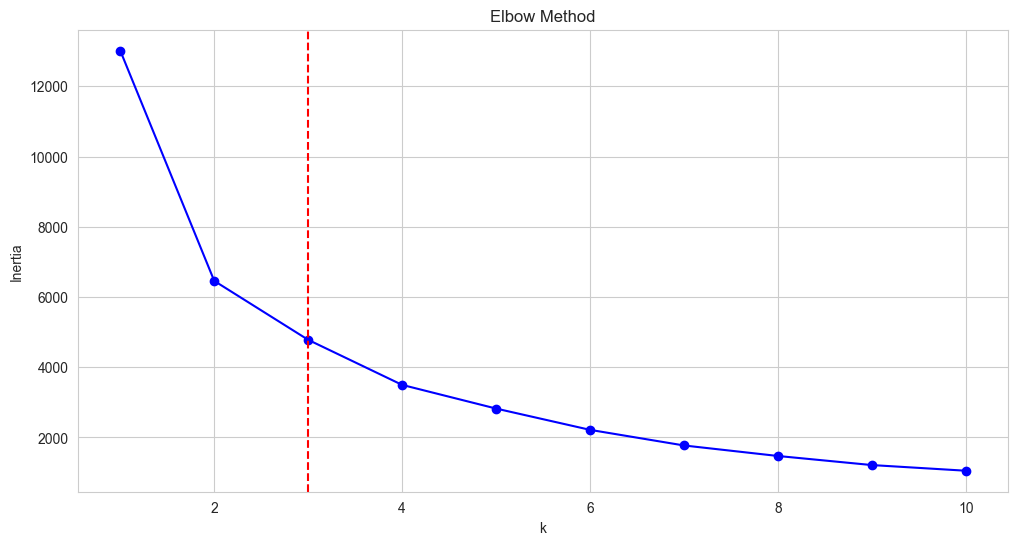

In [7]:
features = customer_summary[['NumTransactions', 'TotalQuantity', 'TotalRevenue']]
scaler = StandardScaler()
X = scaler.fit_transform(features)

inertias = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X).inertia_ for k in range(1,11)]
plt.plot(range(1,11), inertias, 'bo-')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.axvline(3, color='red', linestyle='--')
plt.show()

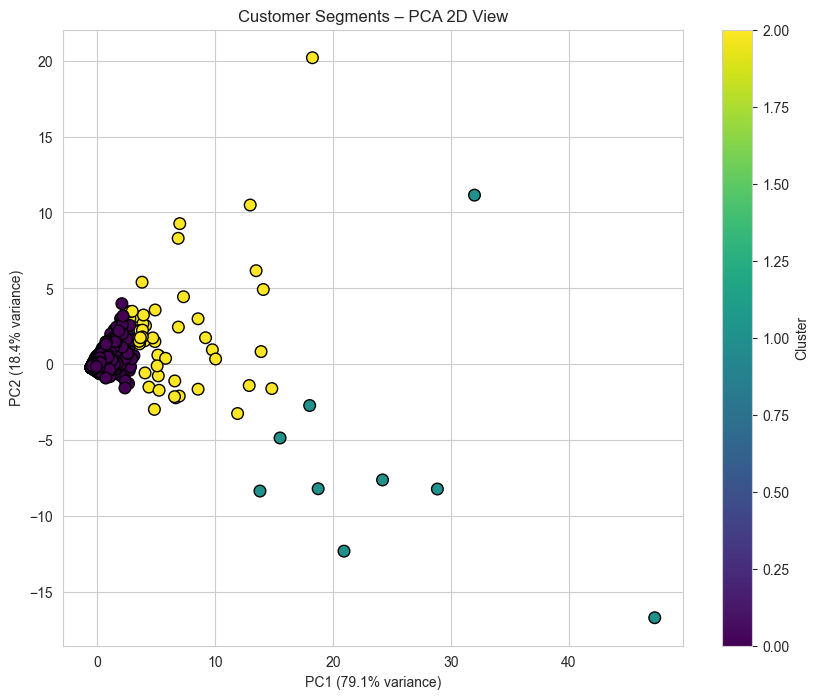

In [8]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
customer_summary['Cluster'] = kmeans.fit_predict(X)

pca = PCA(n_components=2)
pca2d = pca.fit_transform(X)

plt.figure(figsize=(10,8))
plt.scatter(pca2d[:,0], pca2d[:,1], c=customer_summary['Cluster'], cmap='viridis', s=70, edgecolors='k')
plt.title('Customer Segments – PCA 2D View')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(label='Cluster')
plt.show()

In [9]:
print("="*70)
print("CLUSTER INTERPRETATION")
print("="*70)

for i in range(k):
    cluster_data = customer_summary[customer_summary['Cluster'] == i]
    avg_rev = cluster_data['TotalRevenue'].mean()
    
    print(f"\nCluster {i}:")
    print(f" Size: {len(cluster_data)} customers")
    print(f" Avg Revenue: ${avg_rev:,.2f}")
    
    if avg_rev > 100_000:
        print(" Segment: HIGH-VALUE")
        print(" Recommended Action: VIP retention, loyalty rewards.")
    elif avg_rev > 5_000:
        print(" Segment: MID-VALUE")
        print(" Recommended Action: Upsell, increase engagement.")
    else:
        print(" Segment: LOW-VALUE")
        print(" Recommended Action: Win-back campaigns.")

CLUSTER INTERPRETATION

Cluster 0:
 Size: 4279 customers
 Avg Revenue: $1,373.94
 Segment: LOW-VALUE
 Recommended Action: Win-back campaigns.

Cluster 1:
 Size: 9 customers
 Avg Revenue: $161,867.60
 Segment: HIGH-VALUE
 Recommended Action: VIP retention, loyalty rewards.

Cluster 2:
 Size: 50 customers
 Avg Revenue: $31,026.45
 Segment: MID-VALUE
 Recommended Action: Upsell, increase engagement.
